In [2]:
# Monocentric City ABM
#########################
# 
# imports
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import time  
from IPython.display import display, clear_output
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

In [3]:
class Household:
    '''Defines a 'household' that functions as an agent for an ABM. This ABM models a 
    monocentric city with radial and train commuting. Used with the City class.'''
    
    def __init__(self,x,y,income, CBD = [],trainx = [],trainy = [],preference=0, radial_distance=0, train_distance=0):
        '''Initializes the data members for the class.'''
        # location
        self.x = x
        self.y = y
        # income, central business district
        self.income = income
        self.CBD = CBD
        # train location
        self.trainx = trainx
        self.trainy = trainy
        # preferences
        self.preference = preference
        # distances
        self.radial_distance = radial_distance
        self.train_distance = train_distance 
    
    def radial_commute(self, x=None, y=None, CBD=None, train = None):
        '''Computes the radial distance between two points, the location of the agent 
        and the location of the central business district.'''
        # set the value of x and y
        if x is None:
            x = self.x
        if y is None:
            y = self.y
    
        if CBD is None:
            CBD = self.CBD
        # calculate radial distance
        a = (abs(y - CBD[1]))**2
        b = (abs(x - CBD[0]))**2
        c = a + b
        self.radial_distance = round(math.sqrt(c))
        
        return self.radial_distance 
    
    def check_spot(self, other_agents, x, y):
        '''checks if a spot on the map is occupied by another instance
        of the agent class.'''
        
        for agent in other_agents:
            if x == agent.x and y == agent.y:
                return True
        return False
        
    def train_commute(self, x=None, y=None, train = None):
        '''Checks distance to the trian'''
        # set vals
        if x is None:
            x = self.x
        if y is None:
            y = self.y
        # walk is the  distance from agent to the train line
        # train_ride is the distance from the "train stop" to the CBD,
        # will alawys be direct
        train_stops = []
        
        for i in range(5):
            a = (abs(y - self.trainy[i]))**2
            b = (abs(x - self.trainx[i]))**2
            c = a + b
            train_stops.append(round(math.sqrt(c)))   

        walk = min(train_stops)
        trainx = [(70),(71),(72),(73),(74)]
        train_start_x = trainx[train_stops.index(walk)]
        self.train_distance = ((abs(train_start_x - self.CBD[0])* .25) + walk)  
        
        return self.train_distance
    
    def get_location(self):
        '''Returns location of agent.'''
        
        return self.x,self.y
    
    def draw(self,ax):
        '''Draws the agent on the map.'''
        
        ax.scatter(self.x, self.y, s=24.0, c='b', marker='p')

    #define behavior for agent to move to center
    def radial_move(self, other_agents): 
        '''Defines the bahavior for the agent to move radially.'''
        
        # gather all possible positions
        potential_positions = [
            (self.x+1, self.y+1),
            (self.x-1, self.y+1),
            (self.x-1, self.y-1),
            (self.x+1, self.y-1),
            (self.x+1, self.y),
            (self.x-1, self.y),
            (self.x, self.y+1),
            (self.x, self.y-1)]
     
        #changing the distance for a train
        radial_distances = [self.train_commute(x, y, self.CBD) for x, y in potential_positions]
        
        min_distance = float('inf')
        best_position = None
        
        jj = 0
        
        for i, distance in enumerate(radial_distances):
            x, y = potential_positions[i]
            if distance < min_distance and not self.check_spot(other_agents, x, y):
                min_distance = distance
                jj = i
                best_position = potential_positions[jj]
        if best_position is not None:
            self.x, self.y = best_position
            
    def train_move(self, other_agents):  
        '''Defines the bahavior for the agent to move towards the train.'''
        
        # gather potential positions
        potential_positions = [
            (self.x+1, self.y+1),
            (self.x-1, self.y+1),
            (self.x-1, self.y-1),
            (self.x+1, self.y-1),
            (self.x+1, self.y),
            (self.x-1, self.y),
            (self.x, self.y+1),
            (self.x, self.y-1)]
        
        train_distances = [self.train_commute(x, y) for x, y in potential_positions]
        min_distance = float('inf')
        best_position = None
        jj = 0

        for i, distance in enumerate(train_distances):
            x, y = potential_positions[i]
            if distance < min_distance and not self.check_spot(other_agents, x, y):
                min_distance = distance
                jj = i
                best_position = potential_positions[jj]
        if best_position is not None:
            self.x, self.y = best_position

In [4]:
class City():
    '''Defines a 'city' class that functions as the model and visualization for 
    an ABM of a monocentric city. Used with the Household class'''

    def __init__(self, trainx = [(70),(71),(72),(73),(74)] ,trainy = [(75),(75),(75),(75),(75)],size=100, num_agents=50, income_mean=50000, income_std=20000):
        '''Initializes data members.'''
        self.size = size
        # define the city center
        center_x = size // 2
        center_y = size // 2
        self.CBD = [center_x, center_y]
        self.trainx = trainx
        self.trainy = trainy
        # store the agents in a list
        self.households = []
        # environment stuff
        # colors, etc
        self.environ = np.zeros((self.size,self.size,3))
        self.environ[:,:,0] = 0.25
        self.environ[:,:,1] = 0.79
        self.environ[:,:,2] = 0.04
        
        # create the households
        for i in range(num_agents):
            # generate a random starting point for the agents
            x = random.randint(0, size-1)
            y = random.randint(0, size-1)
            income = max(0, random.normalvariate(income_mean, income_std))
            self.households.append(Household(x,y,income,self.CBD,self.trainx,self.trainy))
    
    def get_agents(self):
        '''Returns the households that are in the city.'''
        return self.households
    
    def plot_agents(self):
        '''Function that plots the agents.'''
        
        # initializes x and y coords
        x_coords = []
        y_coords = []
        
        # iterate over households
        for household in self.households:
            x_coords.append(household.x)
            y_coords.append(household.y)
        
        # plots the city
        plt.scatter(x_coords,y_coords)
        plt.scatter(self.CBD[0],self.CBD[1], color = 'r', s = 60)
        plt.text(self.CBD[0] + 2, self.CBD[1] + 2, "City center")
        plt.xlim(0,self.size + 1)
        plt.ylim(0,self.size + 1)
        plt.show()
        
    def simulate(self, tot_time):
        '''Simulates the movement of the agents(Household) in the city.'''
        
        # iterate over total time based on input
        for t in range(tot_time):
            # clears the city
            clear_output(wait=True)
            # plots
            plt.figure(figsize=(10,10))
            plt.imshow(self.environ)
            ax = plt.gca()
            
            # moves the agents, draws
            for household in self.households:
                a = household.radial_commute()
                b = household.train_commute()
                if a <= b:
                    household.radial_move(self.households)
                else:
                    household.train_move(self.households)
                household.draw(ax)
            
            # add marker for CBD
            ax.scatter(self.CBD[0], self.CBD[1], s=60, marker='D', c='r')
            ax.text(self.CBD[0]+2, self.CBD[1]+2, 'CBD')
            # plot the current timestep
            ax.scatter(self.trainx,self.trainy)
            
            
            plt.xlim(0, self.size)  # set the x-axis limit
            plt.ylim(0, self.size)  # set the y-axis limit
            plt.show()  # display the updated figure
            time.sleep(0.001)  # pause the display for a short time

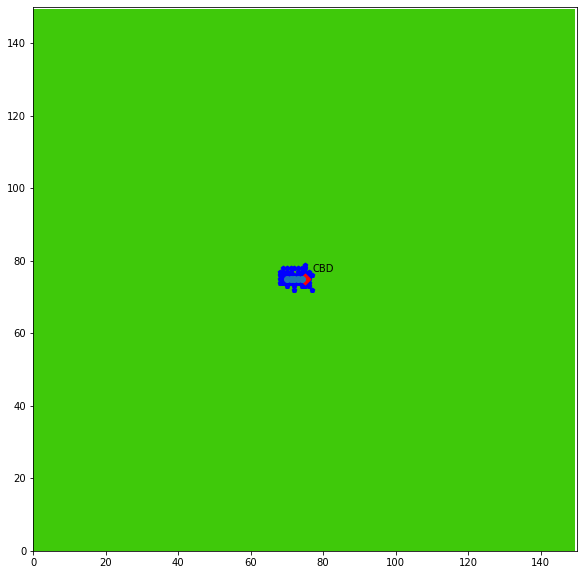

In [5]:
####################
# Run the model
####################
Detroit = City(size=150, num_agents=50, income_mean=60000, income_std=25000)
Detroit.simulate(100)